# HackTheBay: predictive analysis 


## 1. Feature selection

In this notebook, we use the following variables for prediction:
'za_mean', ('lc_21', 'lc_22', 'lc_23', 'lc_24') combined as lc_2t, 'lc_31', ('lc_41', 'lc_42', 'lc_43') combined as lc_4t, 'lc_52', 'lc_71', 'lc_81', 'lc_82', ('lc_90', 'lc_95') combined as lc_9t, 'week', 'dayofweek', 'airtemp_narr',
'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff', 'windspeed_narr', 'wdirection_narr', 'precip24_narr', 'precip48_narr', 'of_dist', 'date_delta'.

Date_delta is a numeric variable which capture the time in seconds from the latest record. We could not keep 'new_date' in a datetime format (not supported by Catboost). The reasoning behind creating date_delta is that other time variables (month, year, week, day of week and quarter) are categorical. They can capture a seasonal phenomenon (pollution from industry on weekdays for example) but not a trend over time.

We removed the following variables:
'new_date' (replaced by date_delta which is numeric), 'latitude', 'longitude', 'huc12_', 'month'\*\*, 'year'\*\*, 'hour'\*\*, 'min'\*\*, 'quarter'\*\*, and 'huc12_enc' (location is captured in of_dist).


The dependant variable (target) is the total nitrogen ('tn') in mg/L.

\* these variables are all related to the location, which is captured by the distance from the outflow (of_dist). We are removing variables which are correlated.

\*\* Time related variables were redudant. We kept dayofweek as a categorical variable to capture changes between weekdays and weekend (if any), and week for seasonality.


## 2. Catboost

Catboost [can deal with missing values internally](https://catboost.ai/docs/concepts/algorithm-missing-values-processing.html) by giving them the minimal value for that feature (which translates into the guarantee to have a split that separates missing values from all other values). We want to test its capabilities on the non-imputed dataset. 

Furthermore, categorical variables in the dataset don't need to be dummified, as an ensemble method [feature scaling is not necessary](https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm).

In [63]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
from datetime import date
from sklearn import metrics
from pandas_profiling import ProfileReport
import shap
import plotly

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

In [2]:
# Import catboost package
import catboost

In [3]:
# Load dataset
df = pd.read_csv('data/model_data_enc.csv', index_col=0)
df.head()

,new_date,latitude,longitude,huc12_,areaacres,za_mean,lc_21,lc_22,lc_23,lc_24,...,humidity_narr,cl_cover_narr,sfc_runoff,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr,of_dist,tn,huc12_enc
54676,2016-01-05 08:45:00,39.21781,-76.70534,20600031102,27666.75,32.130354,0.214800,0.200413,0.131977,0.055303,...,50.019318,0.0,0.000000e+00,8.609411,186.70435,0.007812,0.007812,158.550101,2.049000,2.104850
60973,2018-10-09 09:58:00,38.35250,-77.20510,20700110207,25798.32,31.691293,0.028510,0.003396,0.000560,0.000052,...,96.636920,52.0,0.000000e+00,1.754449,323.09302,0.007812,0.007812,115.828263,1.744333,1.325944
11490,2009-10-26 12:00:00,38.25650,-76.17430,20600050603,26099.19,30.604554,0.006195,0.010593,0.001559,0.000409,...,88.850970,5.0,-9.969210e+36,5.065295,194.99954,0.812500,7.125000,87.737745,0.602200,0.851864
50387,2018-04-18 11:30:00,40.30833,-76.85000,20503051007,17537.59,30.876770,0.181377,0.275393,0.164830,0.094689,...,81.749626,72.0,0.000000e+00,2.318398,315.53265,0.016539,14.628581,233.506891,2.471000,2.310872
64807,2016-02-08 11:45:00,38.19685,-75.97321,20801100503,27245.43,11.127324,0.000000,0.000000,0.000000,0.000000,...,76.556220,0.0,-9.969210e+36,5.175538,191.03735,0.882812,2.671875,82.831920,0.768500,0.835386


In [4]:
df.columns

Index(['new_date', 'latitude', 'longitude', 'huc12_', 'areaacres', 'za_mean',
       'lc_21', 'lc_22', 'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43',
       'lc_52', 'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'month', 'year',
       'week', 'dayofweek', 'hour', 'min', 'quarter', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'windspeed_narr', 'wdirection_narr', 'precip24_narr', 'precip48_narr',
       'of_dist', 'tn', 'huc12_enc'],
      dtype='object')

In [5]:
df['new_date'] = pd.to_datetime(df.new_date)
df.new_date.max()

Timestamp('2020-04-02 12:00:00')

In [6]:
df['date_max'] = df.new_date.max()#pd.to_datetime('2020-04-02 12:00:00')

In [7]:
#Select dates 2016 to now 
df = df[df['new_date'] > '2015-12-31']

In [8]:
df['date_delta'] = (df.date_max.subtract(df.new_date)).dt.total_seconds().astype(int)

In [9]:
df['lc_2t'] = df.lc_21 + df.lc_22 + df.lc_23 + df.lc_24
df['lc_4t'] = df.lc_41 + df.lc_42 + df.lc_43 
df['lc_9t'] = df.lc_90 + df.lc_95

In [10]:
#Remove columns not used for prediction:  Like Justin but I kept dayofweek
df.drop(['new_date', 'date_max', 'latitude', 'longitude', 'huc12_', 'month', 'year', 'hour',
       'min', 'quarter', 'huc12_enc', 'date_max', 'lc_21', 'lc_22', 'lc_23', 'lc_24', 
         'lc_41', 'lc_42', 'lc_43', 'lc_90', 'lc_95'], inplace=True, axis =1)
df.head()

,areaacres,za_mean,lc_31,lc_52,lc_71,lc_81,lc_82,week,dayofweek,airtemp_narr,...,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr,of_dist,tn,date_delta,lc_2t,lc_4t,lc_9t
54676,27666.75,32.130354,0.002001,0.004565,0.010384,0.023661,0.001366,1,1,-8.600067,...,8.609411,186.70435,0.007812,0.007812,158.550101,2.049000,133845300,0.602493,0.331426,0.023259
60973,25798.32,31.691293,0.000095,0.008765,0.002318,0.010403,0.014410,41,1,20.141724,...,1.754449,323.09302,0.007812,0.007812,115.828263,1.744333,46749720,0.032518,0.400908,0.073214
50387,17537.59,30.876770,0.000469,0.000824,0.001750,0.060860,0.018068,16,2,0.966400,...,2.318398,315.53265,0.016539,14.628581,233.506891,2.471000,61777800,0.716289,0.194703,0.002802
64807,27245.43,11.127324,0.000024,0.000000,0.000000,0.000000,0.000000,6,0,5.104523,...,5.175538,191.03735,0.882812,2.671875,82.831920,0.768500,130896900,0.000000,0.000000,0.001510
63775,32516.70,51.747832,0.004630,0.067448,0.044906,0.031727,0.102684,46,1,10.815887,...,4.746507,208.16940,29.852905,30.079468,99.963454,0.680000,43717500,0.075464,0.575265,0.089067


In [13]:
#No field worker would go into waters that are total nitrogen over 50 only 22 values to drop 
df = df[df['tn'] < 50]

In [11]:
ProfileReport(df)

In [12]:
all_cols = df.columns
all_cols

Index(['areaacres', 'za_mean', 'lc_31', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'week', 'dayofweek', 'airtemp_narr', 'precip3_narr', 'humidity_narr',
       'cl_cover_narr', 'sfc_runoff', 'windspeed_narr', 'wdirection_narr',
       'precip24_narr', 'precip48_narr', 'of_dist', 'tn', 'date_delta',
       'lc_2t', 'lc_4t', 'lc_9t'],
      dtype='object')

### Setup Catboost

In [14]:
X = df.drop('tn', axis=1)
y = df.tn

In [15]:
categorical = ['dayofweek']


In [16]:
numeric = all_cols[~all_cols.isin(categorical)]
numeric

Index(['areaacres', 'za_mean', 'lc_31', 'lc_52', 'lc_71', 'lc_81', 'lc_82',
       'week', 'airtemp_narr', 'precip3_narr', 'humidity_narr',
       'cl_cover_narr', 'sfc_runoff', 'windspeed_narr', 'wdirection_narr',
       'precip24_narr', 'precip48_narr', 'of_dist', 'tn', 'date_delta',
       'lc_2t', 'lc_4t', 'lc_9t'],
      dtype='object')

In [17]:
#Change some numericals to categorical variables
X[categorical] = X[categorical].astype(str)

In [18]:
X.dtypes

areaacres          float64
za_mean            float64
lc_31              float64
lc_52              float64
lc_71              float64
lc_81              float64
lc_82              float64
week                 int64
dayofweek           object
airtemp_narr       float64
precip3_narr       float64
humidity_narr      float64
cl_cover_narr      float64
sfc_runoff         float64
windspeed_narr     float64
wdirection_narr    float64
precip24_narr      float64
precip48_narr      float64
of_dist            float64
date_delta           int32
lc_2t              float64
lc_4t              float64
lc_9t              float64
dtype: object

Check for missing values

In [19]:
null_value_stats = df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 4)

In [21]:
cat_features = [X.columns.get_loc(i) for i in categorical]
cat_features

[8]

In [22]:
X.head()

,areaacres,za_mean,lc_31,lc_52,lc_71,lc_81,lc_82,week,dayofweek,airtemp_narr,...,sfc_runoff,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr,of_dist,date_delta,lc_2t,lc_4t,lc_9t
54676,27666.75,32.130354,0.002001,0.004565,0.010384,0.023661,0.001366,1,1,-8.600067,...,0.000000e+00,8.609411,186.70435,0.007812,0.007812,158.550101,133845300,0.602493,0.331426,0.023259
60973,25798.32,31.691293,0.000095,0.008765,0.002318,0.010403,0.014410,41,1,20.141724,...,0.000000e+00,1.754449,323.09302,0.007812,0.007812,115.828263,46749720,0.032518,0.400908,0.073214
50387,17537.59,30.876770,0.000469,0.000824,0.001750,0.060860,0.018068,16,2,0.966400,...,0.000000e+00,2.318398,315.53265,0.016539,14.628581,233.506891,61777800,0.716289,0.194703,0.002802
64807,27245.43,11.127324,0.000024,0.000000,0.000000,0.000000,0.000000,6,0,5.104523,...,-9.969210e+36,5.175538,191.03735,0.882812,2.671875,82.831920,130896900,0.000000,0.000000,0.001510
63775,32516.70,51.747832,0.004630,0.067448,0.044906,0.031727,0.102684,46,1,10.815887,...,0.000000e+00,4.746507,208.16940,29.852905,30.079468,99.963454,43717500,0.075464,0.575265,0.089067


In [23]:
from catboost import CatBoostRegressor, Pool, cv

In [26]:
model = CatBoostRegressor(
    iterations = 2000,
    learning_rate = 0.05,
    loss_function = 'RMSE',
    task_type = 'GPU')


In [27]:
model.fit(X_train, y = y_train, cat_features=cat_features,
          eval_set = (X_test, y_test), plot=True, verbose = 1000)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3369011	test: 2.3816914	best: 2.3816914 (0)	total: 21.7ms	remaining: 43.3s
1000:	learn: 0.6272149	test: 0.9881577	best: 0.9879010 (954)	total: 22.7s	remaining: 22.6s
1999:	learn: 0.5666454	test: 0.9788350	best: 0.9769673 (1731)	total: 46s	remaining: 0us
bestTest = 0.9769672527
bestIteration = 1731
Shrink model to first 1732 iterations.


Let's tune the hyperparameters:

In [28]:
from catboost import Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)
test_pool = Pool(X_test, 
                 cat_features=cat_features) 

In [29]:
param_grid = {'learning_rate': [0.1, 0.05],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 5, 9],
              'bagging_temperature': [0, 0.5, 1.0],
              'one_hot_max_size': [2, 14, 25],
              'random_strength': [1, 10, 20]}
model2 = CatBoostRegressor(
    iterations = 2500,
    loss_function = 'RMSE',
    verbose = 500,
    task_type = 'GPU')

In [39]:
randomized_search_result = model2.randomized_search(param_grid,
                train_pool,
                cv=3,
                n_iter=50,
                partition_random_seed=2,
                calc_cv_statistics=True,
                search_by_train_test_split=True,
                refit=True,
                shuffle=True,
                stratified=None,
                train_size=0.8,
                verbose=10,
                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.9924594	best: 0.9924594 (0)	total: 25.4s	remaining: 20m 44s
10:	loss: 1.0360662	best: 0.9924594 (0)	total: 6m	remaining: 21m 16s
20:	loss: 0.9886682	best: 0.9688733 (16)	total: 13m 44s	remaining: 18m 57s
30:	loss: 1.0416546	best: 0.9655219 (21)	total: 22m 40s	remaining: 13m 53s
40:	loss: 1.0324623	best: 0.9613202 (32)	total: 28m 37s	remaining: 6m 16s
49:	loss: 1.0043681	best: 0.9481473 (43)	total: 39m 38s	remaining: 0us
Estimating final quality...


In [40]:
model2.get_params()

{'iterations': 2500,
 'loss_function': 'RMSE',
 'verbose': 500,
 'task_type': 'GPU',
 'random_strength': 1,
 'depth': 10,
 'one_hot_max_size': 25,
 'l2_leaf_reg': 9,
 'bagging_temperature': 1.0,
 'learning_rate': 0.1}

In [41]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,of_dist,31.008632
1,lc_82,15.110921
2,lc_52,13.960630
3,lc_9t,6.596072
4,lc_81,5.033485
5,za_mean,4.469672
6,precip24_narr,3.813906
7,lc_71,3.614064
8,lc_2t,3.162211
9,lc_4t,3.126720


Checking the performance metrics of this model:

In [42]:
y_pred = model2.predict(X_test)

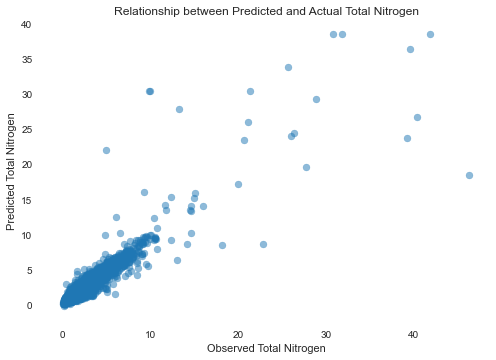

In [43]:
# Plot observed vs predicted delivery week
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("Observed Total Nitrogen")
plt.ylabel("Predicted Total Nitrogen")
plt.title("Relationship between Predicted and Actual Total Nitrogen")
plt.show()

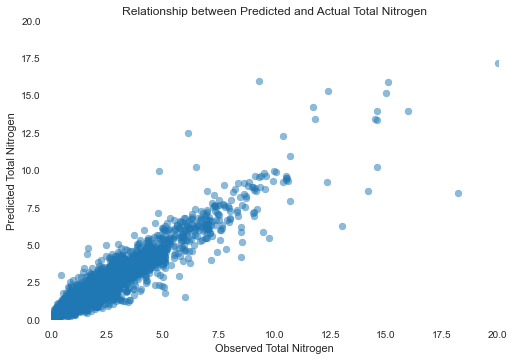

In [44]:
# Plot observed vs predicted delivery week
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("Observed Total Nitrogen")
plt.ylabel("Predicted Total Nitrogen")
plt.title("Relationship between Predicted and Actual Total Nitrogen")
plt.xlim((0,20))
plt.ylim((0,20))

plt.show()

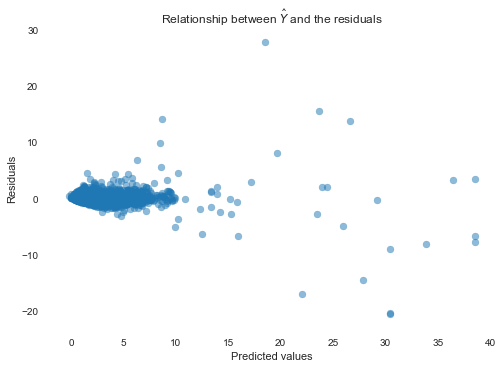

In [45]:
#Distribution of the residuals
plt.scatter(y_pred, (y_test - y_pred), alpha = 0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Relationship between $\hatY$ and the residuals")
plt.show()

In [46]:
# Performance metrics
errors = abs(round(y_pred - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'mg/L')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'mg/L.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
print('MAPE:', round(np.mean(mape), 2), '%.')
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 0.27 mg/L
Standard deviation of absolute error: 0.95 mg/L.
MAPE: 12.44 %.
Accuracy: 87.56 %.


In [48]:
print(r2_score(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.8435469673925473
0.8435541907266202
0.9645451777555596


In [50]:
res = model2.calc_feature_statistics(X_train,
                                    y_train,
                                    feature=18,
                                    plot=True)

In [51]:
res = model2.calc_feature_statistics(X_train,
                                    y_train,
                                    feature=19,
                                    plot=True)

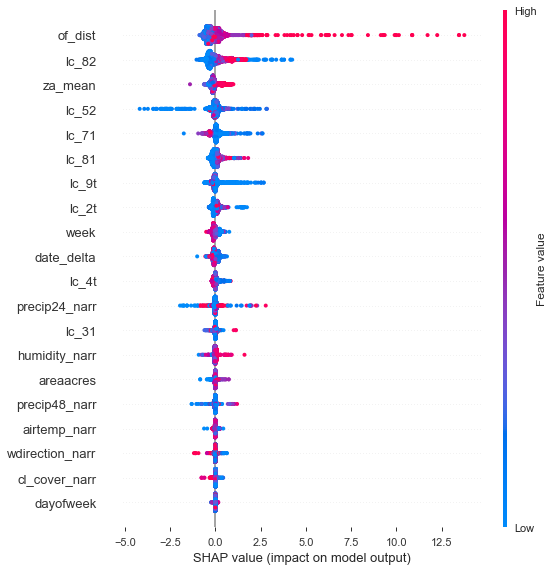

In [52]:
shap_values = model2.get_feature_importance(test_pool, type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test)

# shap.initjs()
# shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

Once tuned, the results are promising. To further improve the model we could train only the features cumulating to 95% of importance.

In [53]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,of_dist,31.008632
1,lc_82,15.110921
2,lc_52,13.960630
3,lc_9t,6.596072
4,lc_81,5.033485
5,za_mean,4.469672
6,precip24_narr,3.813906
7,lc_71,3.614064
8,lc_2t,3.162211
9,lc_4t,3.126720


In [54]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, 
                                      model2.get_feature_importance(Pool(X, label=y, 
                                                                        cat_features=cat_features)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', 
                                          na_position='last')

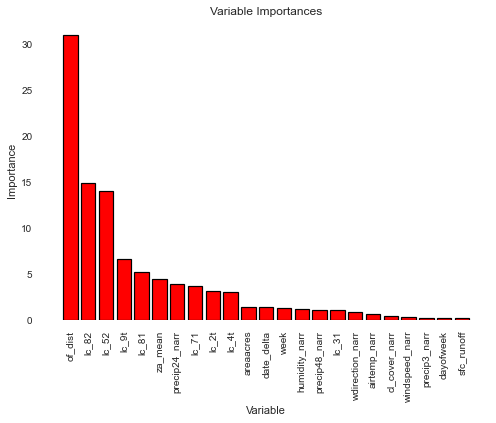

In [55]:
# list of x locations for plotting
x_values = list(range(len(feature_score)))
# Make a bar chart
plt.bar(x_values, feature_score['Score'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_score['Feature'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

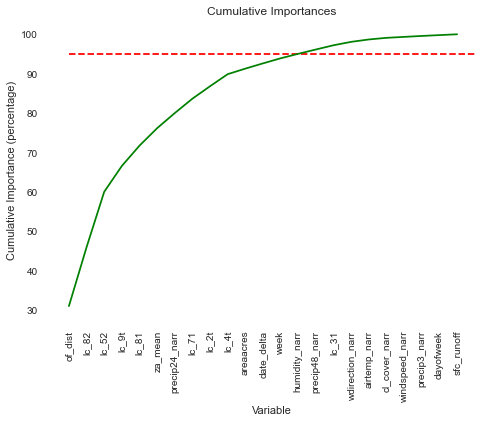

In [56]:
# Cumulative importances
cumulative_importances = np.cumsum(feature_score['Score'])
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 95, xmin=0, xmax=len(feature_score['Score']), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_score['Feature'], rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance (percentage)'); plt.title('Cumulative Importances');

In [57]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
threshold= np.where(cumulative_importances > 95)[0][0] + 1
print('Number of features for 95% importance:', np.where(cumulative_importances > 95)[0][0] + 1)

Number of features for 95% importance: 14


In [58]:
# List of features for later use
feature_list = list(X.columns)
# Extract the names of the most important features
important_feature_names = feature_score[0:threshold]['Feature']
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X = X.iloc[:, important_indices]
# Sanity check on operations
print('Important features X shape:', important_X.shape)

Important features X shape: (16948, 14)


In [59]:
num_cols = important_X._get_numeric_data().columns
cols = important_X.columns
important_cat_features = list(set(cols) - set(num_cols))
important_cat_features

[]

In [60]:
cat_features = [important_X.columns.get_loc(i) for i in important_cat_features]
cat_features

[]

In [61]:
important_X_train, important_X_test, y_train, y_test = train_test_split(important_X, y, test_size = 0.3, random_state= 2)

In [72]:
train_pool2 = Pool(important_X_train, 
                  y_train, 
                  cat_features=cat_features)
test_pool2 = Pool(important_X_test, 
                  y_test, 
                  cat_features=cat_features)

In [64]:
# Same parameters as above
model3 = CatBoostRegressor(
    iterations = 2500,
    loss_function = 'RMSE',
    verbose = 500,
    task_type = 'GPU')

In [65]:
randomized_search_result = model3.randomized_search(param_grid,
                train_pool2,
                cv=3,
                n_iter=50,
                partition_random_seed=2,
                calc_cv_statistics=True,
                search_by_train_test_split=True,
                refit=True,
                shuffle=True,
                stratified=None,
                train_size=0.8,
                verbose=10,
                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8703609	best: 0.8703609 (0)	total: 24s	remaining: 19m 33s
10:	loss: 0.8212134	best: 0.7864144 (3)	total: 5m 9s	remaining: 18m 17s
20:	loss: 0.8510429	best: 0.7864144 (3)	total: 11m 18s	remaining: 15m 37s
30:	loss: 0.8063862	best: 0.7864144 (3)	total: 20m 1s	remaining: 12m 16s
40:	loss: 0.8121162	best: 0.7864144 (3)	total: 25m 30s	remaining: 5m 35s
49:	loss: 0.7817574	best: 0.7817574 (49)	total: 37m 2s	remaining: 0us
Estimating final quality...


In [66]:
model3.get_params()

{'iterations': 2500,
 'loss_function': 'RMSE',
 'verbose': 500,
 'task_type': 'GPU',
 'random_strength': 20,
 'depth': 10,
 'one_hot_max_size': 14,
 'l2_leaf_reg': 9,
 'bagging_temperature': 1.0,
 'learning_rate': 0.1}

In [67]:
y_pred = model3.predict(important_X_test)

In [68]:
# Performance metrics
errors = abs(round(y_pred - y_test, 0))
print('Average absolute error:', round(np.mean(errors), 2), 'mg/L')
print('Standard deviation of absolute error:', round(np.std(errors), 2), 'mg/L.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
print('MAPE:', round(np.mean(mape), 2), '%.')
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 0.28 mg/L
Standard deviation of absolute error: 0.84 mg/L.
MAPE: 13.81 %.
Accuracy: 86.19 %.


In [70]:
print(r2_score(y_test, y_pred))
print(explained_variance_score(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.8640843133505167
0.8640893206736522
0.8749729744229809


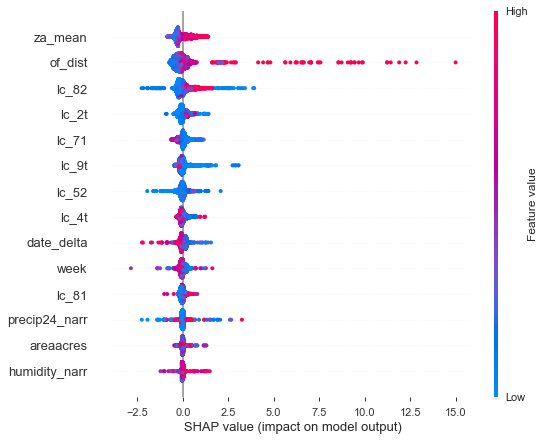

In [74]:
shap_values = model3.get_feature_importance(test_pool2, type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, important_X_test)

# shap.initjs()
# shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

Limiting to features to 95% of importance lead to better $R^2$.

In [75]:
model3.save_model('catboost_model',
           format="cbm",
           export_parameters=None,
           pool=None)